In [1]:
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# carregando o dataset
csv_path = "dataset_pedidoajuda.csv"
df = pd.read_csv(csv_path)

In [3]:
# preparando variáveis categóricas
encoder_tipo = LabelEncoder()
encoder_crianca = LabelEncoder()
encoder_urgencia = LabelEncoder()

In [4]:
# codificar colunas categóricas
X_tipo = encoder_tipo.fit_transform(df["TipoAjuda"])
X_crianca = encoder_crianca.fit_transform(df["CriancasNoLocal"])
X_pessoas = df["PessoasNoLocal"].values
X_texto = TfidfVectorizer().fit_transform(df["SituacaoDeRisco"])
y = encoder_urgencia.fit_transform(df["NivelUrgencia"])

In [5]:
# juntando tudo em um unico X
X_numerico = pd.DataFrame({"TipoAjuda": X_tipo, "CriancasNoLocal": X_crianca, "PessoasNoLocal": X_pessoas}).values
X_final = hstack([X_numerico, X_texto])


In [6]:
# dividindo os dados com estratificação
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# treinando o modelo com Gradient Boosting
modelo = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
modelo.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=200, random_state=42)

In [8]:
# avaliando o modelo
y_pred = modelo.predict(X_test)
print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred, target_names=encoder_urgencia.classes_))

Relatório de Classificação:

              precision    recall  f1-score   support

        ALTA       1.00      1.00      1.00        32
       BAIXA       1.00      1.00      1.00        20
       MEDIA       1.00      1.00      1.00        24

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76



In [9]:
# exemplo de previsão ALTA
exemplo = pd.DataFrame([{ 
    "TipoAjuda": encoder_tipo.transform(["Resgate"])[0],
    "CriancasNoLocal": encoder_crianca.transform(["S"])[0],
    "PessoasNoLocal": 6
}])

texto = ["Família ilhada em área de risco"]
texto_vetor = TfidfVectorizer().fit(df["SituacaoDeRisco"]).transform(texto)
X_exemplo = hstack([exemplo.values, texto_vetor])

pred_urgencia = modelo.predict(X_exemplo)
print("\nPrevisão de urgência para o pedido:", encoder_urgencia.inverse_transform(pred_urgencia)[0])


Previsão de urgência para o pedido: ALTA


In [10]:
# exemplo de previsão MEDIA
exemplo1 = pd.DataFrame([{ 
    "TipoAjuda": encoder_tipo.transform(["Água"])[0],
    "CriancasNoLocal": encoder_crianca.transform(["S"])[0],
    "PessoasNoLocal": 4
}])

texto1 = ["Local sem abastecimento de água há dois dias com crianças pequenas"]
texto_vetor1 = TfidfVectorizer().fit(df["SituacaoDeRisco"]).transform(texto1)
X_exemplo1 = hstack([exemplo1.values, texto_vetor1])

pred1 = modelo.predict(X_exemplo1)
print("Previsão de urgência para o pedido:", encoder_urgencia.inverse_transform(pred1)[0])


Previsão de urgência para o pedido: MEDIA


In [11]:
# exemplo de previsão BAIXA
exemplo3 = pd.DataFrame([{ 
    "TipoAjuda": encoder_tipo.transform(["Água"])[0],
    "CriancasNoLocal": encoder_crianca.transform(["N"])[0],
    "PessoasNoLocal": 2
}])

texto3 = ["Solicitação de água para uso doméstico, sem situação emergencial"]
texto_vetor3 = TfidfVectorizer().fit(df["SituacaoDeRisco"]).transform(texto3)
X_exemplo3 = hstack([exemplo3.values, texto_vetor3])

pred3 = modelo.predict(X_exemplo3)
print("Previsão de urgência para o pedido:", encoder_urgencia.inverse_transform(pred3)[0])


Previsão de urgência para o pedido: BAIXA


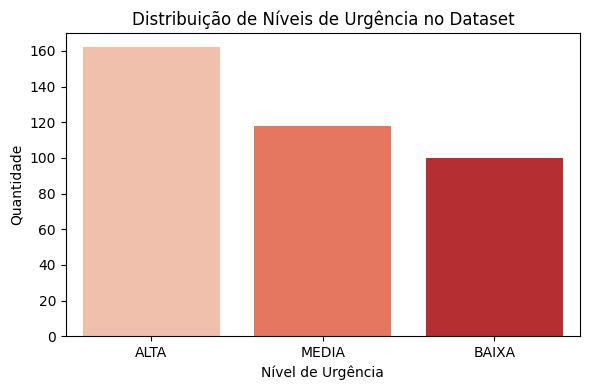

In [12]:
# grafico de distribuição das classes no dataset
plt.figure(figsize=(6, 4))
sns.countplot(x="NivelUrgencia", data=df, hue="NivelUrgencia", dodge=False, palette="Reds", legend=False)
plt.title("Distribuição de Níveis de Urgência no Dataset")
plt.xlabel("Nível de Urgência")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()


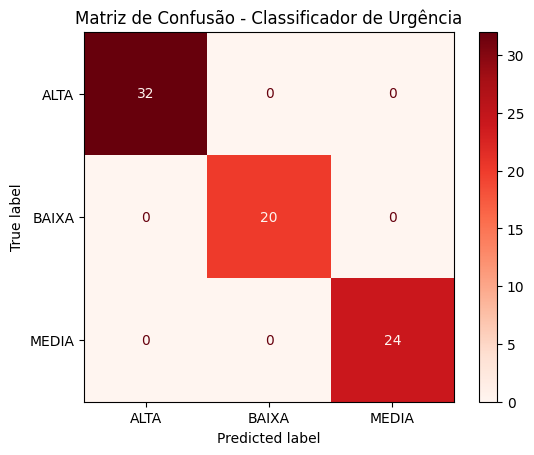

In [13]:
# grafico de matriz de Confusão

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder_urgencia.classes_)
disp.plot(cmap='Reds')
plt.title("Matriz de Confusão - Classificador de Urgência")
plt.show()


In [14]:

# salvar modelo e encoders
joblib.dump(modelo, "modelo_urgencia.pkl")
joblib.dump(encoder_tipo, "encoder_tipo.pkl")
joblib.dump(encoder_crianca, "encoder_crianca.pkl")
joblib.dump(encoder_urgencia, "encoder_urgencia.pkl")

['encoder_urgencia.pkl']